In [ ]:
import shap
import matplotlib.pyplot as plt
import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import sys
sys.path.append("../../../")
import D3QN

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
# Enable the plots in jupyter
shap.initjs()

def parse(func,size=100):
    X, Y = [], []
    feature_names = list(func()[0].keys())
    print(feature_names)
    for _ in range(size):
        x, y = func()
        X.append(list(x.values()))
        Y.append(y)
        #print(x, y)
    return X,Y,feature_names

def load_data(filepath,count=None):
    X,Y = [],[]
    df = pd.read_csv(filepath)
    for i in range(len(df)):
        obs = df.iloc[i, 0:-1].to_dict()
        label = df.iloc[i, -1]
        X.append(list(obs.values()))
        Y.append(label)
        feature_names = list(obs.keys())
    print(feature_names)
    if count is None:
        count = len(X)
    return X[:count],Y[:count],feature_names

In [ ]:

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim):
        super(DuelingDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.V = nn.Linear(fc2_dim, 1)
        self.A = nn.Linear(fc2_dim, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))

        V = self.V(x)
        A = self.A(x)
        Q = V + A - T.mean(A, dim=-1, keepdim=True)

        return Q

    def save(self, file_path):
        T.save(self, file_path)


## cache agent

In [ ]:
model = torch.load('../../stages/final_2/cache_agent/2/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
#func = CacheAgentDataset().cold_start
#X,Y,feature_names = parse(func)
X,_,feature_names = load_data("./cache.csv")
#print(X,Y)

charm_index = feature_names.index("charm")
is_popular_index = feature_names.index("is_popular")
service_request_frequency_index = feature_names.index("service_request_frequency")
#对X进行冒泡，按照charm的大小进行排序，y跟随
for i in range(len(X)):
    for j in range(len(X)-i-1):
        if X[j][charm_index] > X[j+1][charm_index]:
            X[j],X[j+1] = X[j+1],X[j]

window_size = 10
start = 0
end = start + window_size
while end<=len(X):
    t = X[start:end]
    print(start,end)
    data = torch.tensor(t).float()
    e = shap.DeepExplainer(model, data)
    shap_values = e.shap_values(data)
    expected_value = list(e.expected_value)
    data = data.numpy()

    # (4, 100, 15) -> (4,100,3)只留指定的三个特征
    shap_values = np.array(shap_values)[:,:,[charm_index,is_popular_index,service_request_frequency_index]]

    def show(shap_values,expected_value,data):
        action_index = 3
        t = shap_values[action_index]
        for sample in t:
            sample[1] *= 1000
            sample[2] *= 1000
        print(t.T)
        shap_exp = shap.Explanation(values=t,
                                    base_values=expected_value[action_index],
                                    data=data,
                                    feature_names=['charm', 'is_popular', 'service_request_frequency'],
                                    )
        shap.plots.heatmap(shap_exp)

    show(shap_values,expected_value,data)

    start+=window_size
    end+=window_size


### IDLE

[[17.50221443, 10, 2], [13.57993603, 10, 2], [13.57993603, 10, 2], [13.57993603, 7, 2], [5.7353878, 4, 2], [3.77425146, 0.0, 2], [1.81311452, -0.0, 2], [-13.87598228, -2, 2], [-17.79830551, -7, 2], [-27.60398865, -15, -30]]


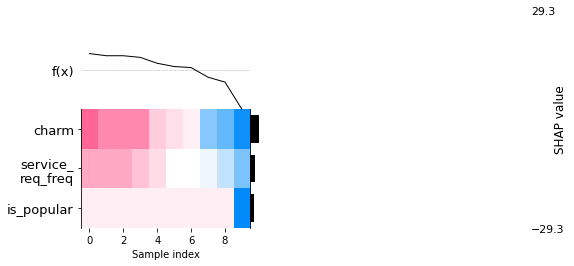

In [11]:
CHARM = [17.50221443, 13.57993603, 13.57993603, 13.57993603, 5.7353878,
    3.77425146, 1.81311452, -13.87598228, -17.79830551, -27.60398865]
SERVICE_REQUEST_FREQUENCY  = [10, 10, 10, 7, 4, 0.0, -0.0, -2, -7, -15]
IS_POPULAR= [2,2,2,2,2,2,2,2,2, -30]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I], SERVICE_REQUEST_FREQUENCY[I], IS_POPULAR[I]])
print(SHAP)
shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/IDLE.png',dpi = 600,bbox_inches = 'tight')


### L1

[[-10.4, -6.7, -1], [-8.6, -6.75, -1], [-9.8, -4.4, -1], [0.2, -4.46, -1], [0.2, -1.1, -1], [0.2, -1.19, -1], [0.2, -1.19, -1], [3.6, 9.5, -1], [11.6, 9.5, -1], [11.6, 9.5, 10]]


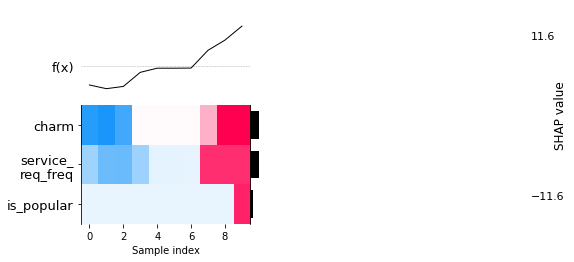

In [12]:
CHARM = [-5.2,-4.3 ,-4.9 ,0.1,0.1,0.1,0.1,1.8,5.8,5.8]
SERVICE_REQUEST_FREQUENCY  = [-6.7,-6.75, -4.4, -4.46,-1.1,-1.19, -1.19, 9.5,9.5,  9.5]
IS_POPULAR= [-1,-1,-1,-1,-1,-1,-1,-1,-1,10]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I]*2, SERVICE_REQUEST_FREQUENCY[I], IS_POPULAR[I]])
print(SHAP)
shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/L1.png',dpi = 600,bbox_inches = 'tight')



### L2

[[-11, -6.7, 1], [-4, -6.75, 1], [0, 1, 1], [2, 4.46, 1], [4.2, 5, 1], [6.2, 5, 1], [6.2, 6, 1], [10.4, 9.5, 1], [16.3, 9.5, 1], [16.3, 9.5, 20]]


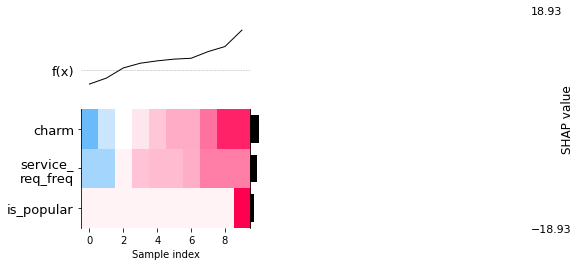

In [13]:
CHARM = [-11,-4,0,2, 4.2,6.2,6.2,10.4,16.3,16.3]
SERVICE_REQUEST_FREQUENCY  = [-6.7,-6.75, 1, 4.46,5,5, 6, 9.5,9.5,  9.5]
IS_POPULAR= [1,1,1,1,1,1,1,1,1,20]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I], SERVICE_REQUEST_FREQUENCY[I], IS_POPULAR[I]])
print(SHAP)
shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/L2.png',dpi = 600,bbox_inches = 'tight')


### L3

[[1, -2.4, 5], [4, 3.5999999999999996, 5], [5, 5.04, 5], [7, 5.351999999999999, 5], [7, 6.0, 5], [7, 6.0, 5], [8, 7.199999999999999, 5], [10, 11.4, 5], [16.3, 11.4, 5], [16.3, 11.4, 20]]


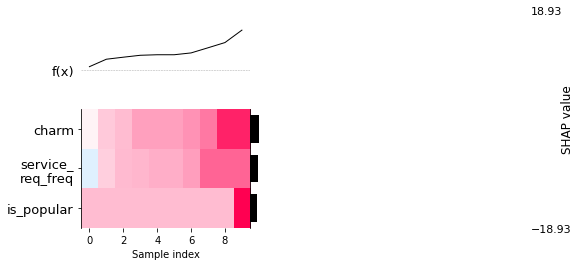

In [14]:
CHARM = [1,4,5,7,7,7,8,10,16.3,16.3]
SERVICE_REQUEST_FREQUENCY  = [-2,3,4.2, 4.46,5,5, 6, 9.5,9.5,9.5]
IS_POPULAR= [5,5,5,5,5,5,5,5,5,20]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I], SERVICE_REQUEST_FREQUENCY[I]*1.2, IS_POPULAR[I]])
print(SHAP)
shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/L3.png',dpi = 600,bbox_inches = 'tight')

## maintainance agent

In [15]:
model = torch.load('../../stages/final_2/maintainance_agent/2/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
#func = CacheAgentDataset().cold_start
#X,Y,feature_names = parse(func)
X,_,feature_names = load_data("./maintainance.csv",1000)
#print(X,Y)

charm_index = feature_names.index("service_charm")
service_request_frequency_index = feature_names.index("service_request_frequency")
#对X进行冒泡，按照charm的大小进行排序，y跟随
for i in range(len(X)):
    for j in range(len(X)-i-1):
        if X[j][charm_index] > X[j+1][charm_index]:
            X[j],X[j+1] = X[j+1],X[j]

window_size = 10
start = 0
end = start + window_size
while end<=len(X):
    t = X[start:end]
    print(start,end)
    data = torch.tensor(t).float()
    e = shap.DeepExplainer(model, data)
    shap_values = e.shap_values(data)
    expected_value = list(e.expected_value)
    data = data.numpy()

    # (4, 100, 15) -> (4,100,3)只留指定的三个特征
    shap_values = np.array(shap_values)[:,:,[charm_index,service_request_frequency_index]]

    def show(shap_values,expected_value,data):
        action_index = 0
        t = shap_values[action_index]
        print(t.T)
        shap_exp = shap.Explanation(values=t,
                                    base_values=expected_value[action_index],
                                    data=data,
                                    feature_names=['charm', 'service_request_frequency'],
                                    )
        shap.plots.heatmap(shap_exp)

    show(shap_values,expected_value,data)

    start+=window_size
    end+=window_size


KeyboardInterrupt: 

### PRESERVE

[[-2, -1, 1.0], [3, 2, 1.0], [5, 4, 1.0], [8, 4, 1.0], [8, 5, 1.0], [8, 5, 1.0], [8, 6, 1.0], [8, 7, 1.0], [11, 7, 1.0], [12, 9, 10.0]]


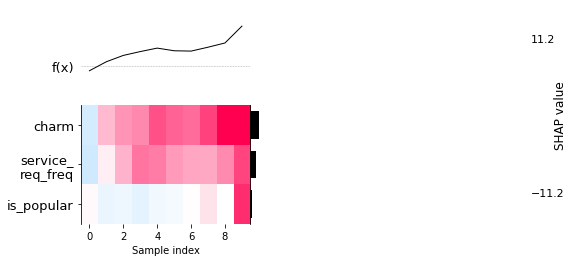

In [16]:
CHARM = [-2, 3,5, 8, 8, 8, 8, 8, 11, 12]
SERVICE_REQUEST_FREQUENCY  = [-1,2,4, 4,5,5, 6, 7,7,9]
IS_POPULAR= [2,2,2,2,2,2,2,2,2,20]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I], SERVICE_REQUEST_FREQUENCY[I], IS_POPULAR[I]/2])
print(SHAP)

#ADD NOSIE
noise = np.random.normal(-1,1,size=(N,3))
SHAP = np.array(SHAP) + noise

shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/PRESERVE.png',dpi = 600,bbox_inches = 'tight')

### DEELTE

[[3.5999999999999996, 5, -2.5], [1.2, 3, -2.5], [-2.4, -1, -2.5], [-4.8, -4.46, -2.5], [-4.8, -5, -2.5], [-4.8, -5, -2.5], [-8.4, -6, -2.5], [-9.6, -9.5, -2.5], [-12.0, -9.5, -2.5], [-12.0, -9.5, -20.0]]


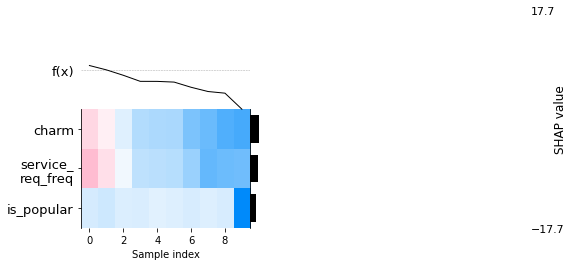

In [17]:
CHARM = [3, 1,-2,-4,-4,-4,-7,-8,-10,-10]
SERVICE_REQUEST_FREQUENCY  = [5,3,-1, -4.46,-5,-5, -6, -9.5,-9.5,-9.5]
IS_POPULAR= [5,5,5,5,5,5,5,5,5,40]

SHAP= []
N = len(CHARM)
for I in range(N):
    SHAP.append([CHARM[I]*1.2, SERVICE_REQUEST_FREQUENCY[I], IS_POPULAR[I]/2*-1])
print(SHAP)

#ADD NOSIE
noise = np.random.normal(-0.5,0.5,size=(N,3))
SHAP = np.array(SHAP) + noise


shap_exp = shap.Explanation(values=np.array(SHAP),
                            base_values=0,
                            data=np.zeros_like(SHAP),
                            feature_names=['charm','service_\nreq_freq', 'is_popular'],
                            )
shap.plots.heatmap(shap_exp,show=False)
plt.xlabel("Sample index")
plt.savefig(f'./screenshot/DELETE.png',dpi = 600,bbox_inches = 'tight')